# Carry signals

#### by Gustavo Soares

In this notebook you will apply a few things you learned in our Python lecture [FinanceHub's Python lectures](https://github.com/Finance-Hub/FinanceHubMaterials/tree/master/Python%20Lectures):

* You will use and manipulate different kinds of variables in Python such as text variables, booleans, date variables, floats, dictionaries, lists, list comprehensions, etc.;
* We will also use `Pandas.DataFrame` objects and methods which are very useful in manipulating financial time series;
* You will use if statements and loops, and;
* You will use [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg) for fetching data from a Bloomberg terminal. If you are using this notebook within BQNT, you may want to use BQL for getting the data.

## Basic imports


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bloomberg import BBG
bbg = BBG() # because BBG is a class, we need to create an instance of the BBG class wihtin this notebook, here deonted by bbg

## Carry

The concept of carry arised in currency markets but it can be applied to any asset. Any security or derivative expected return can be decomposed into its “carry” – an ex-ante and model-free characteristic – and its expected price appreciation. So, "carry" can be understood as the expected return of a security or derivative if there is no change in underlying prices. That is, if "nothing happens", i.e., prices do not move and only time passes, that security or derivative will earn its "carry".

The concept of carry has been shown to be a good predictor or returns cross-sectionally (going long securities with high carry while at the same time going short securities with low carry) and in time series (going long a particular security when carry is positive or historically high and short when carry is negative or historically low). So, the concept of "carry" provides a unifying framework for return predictability and gives orgin to carry strategies across a host of different asset classes, including global equities, global bonds, commodities, US Treasuries, credit, and options. Carry strategies are commonly exposed to global recession, liquidity, and volatility risks, though none fully explain carry’s premium.

[Koijen, Moskowitz, Pedersen, and Vrugt (2016)](https://ssrn.com/abstract=2298565) is a great reference for discussing cross-sectional carry strategies in several different markets. There are typically market-neutral carry strategies where we are always long some currencies, rates, commodities and indices and short some others. [Baz, Granger, Harvey, Le Roux, and Rattray (2015)](https://ssrn.com/abstract=2695101) discusses in detail the differences between cross-sectional strategies and time series strategies for three different factors, including carry. It is really important to understand the difference. [Baltas (2017)](https://doi.org/10.1016/B978-1-78548-201-4.50013-1) also looks at carry stratgies, both cross-sectional and time series, across different futures markets (commodities, equity indices and government bonds). He also discusses the benefits of constructing a multi-asset carry strategies.

Here in this notebook, we just follow [Koijen, Moskowitz, Pedersen, and Vrugt (2016)](https://ssrn.com/abstract=2298565) and show how, using Bloomberg data, calculate carry metrics for different asset classes.


### Carry in FX

Let's start with the best known case, which is carry in currencies. For that, let's take the USDBRL and see how we can compute carry for that currency.

#### Deposit rates

The “classic” definition of currency carry is the local deposit interest rate in the corresponding
country. This definition captures an investment in a currency by literally putting cash into a country’s money market, which earns the interest rate if the exchange rate (the “price of the currency”) does not change. Typically, we would use the
BRL 3M deposit rate (BCDRC BDSR Curncy on Bloomberg) which is the interest rate that a bank will charge for lending or pay for borrowing in BRL. For shorter investment horizons, we could pick shorter tenors such as 1M. However, in terms of predictability of future returns there should be little difference in using 1M, 3M or 6M deposit rates in your carry signal. As a matter of fact, now that many currencies have very small short term rates, many quantitative strategies have been using 2Y rates in their carry signals, even when the signal are meant to be predictive over relatively short investment horizons of 1M or 3M. So, in the case of 3M rates, we can define the annualized USDBRL carry as:

$$
Carry_{USDBRL}^{3M} = \frac{1+r_{USD}}{1+r_{BRL}}-1
$$

where $r_{USD}$ is the 3M USD deposit rate and $r_{BRL}$ is the 3M BRL interest rate.

Note that if we were calculating carry for BRLUSD, it would be a different number. This is important because some curruncies, like the BRL, are quoted as USDBRL and some currencies, like the EUR, are quoted as EURUSD. So, when trading FX, make sure your carry signal is calculated according to whethere you are trading XXXYYY or YYYXXX!

#### Forwards

Recall that by a no-arbitrage argument a currency 3M forward contract should be prices by:

$$
F_{USDBRL}^{3M} = S_{USDBRL} \times \Big(\frac{1+r_{BRL}}{1+r_{USD}}\Big)^{3/12}
$$

where $S_{USDBRL}$ is the spot USDBRL exchange rate. So, an alternative way of defining the 3M annualized carry in USDBRL is:


$$
Carry_{USDBRL}^{3M} = \Big(\frac{S_{USDBRL}}{F_{USDBRL}^{3M}}\Big)^{12/3}-1
$$


#### Volatility adjusted carry

The forwards based definition of $Carry_{USDBRL}^{3M}$ above suggests that the expected return of buying a certain notional, $N$, of 3M forward contract at price $F_{USDBRL}$ expects to earn

$$
N \times \Big(\big(1+Carry_{USDBRL}^{3M}\big)^{3/12}-1\Big)
$$

in profits if deposit rates $r_{USD}$ and $r_{BRL}$ and the spot exchange rate $S_{USDBRL}$ remains constant over the 3M period investment horizon. This is the right intuition for the concept of carry in FX.

However, it is important to note that this trade, buying a 3M forward contract at price $F_{USDBRL}$ and unwinding it at maturity, does not really require the full notional, $N$ in capital. Let's call the actual required capital $X < N$, the "margin amount". The margin $X$ is the actual cash amount needed to operate unfunded derivatives contracts like FX forwards.

An investor typically allocates a fraction of $N$, sometimes as litle as 2% or 3% of $N$, as margin. Let's say $X = k \times N$, then the carry return over the allocated cash capital $X$ is given by:

$$
k^{-1} \times \Big(\big(1+Carry_{USDBRL}^{3M}\big)^{3/12}-1\Big)
$$

Hence, by using a scaling factor $k$ one can modify the definition of carry to be consistent with the returns per unit of allocated capital. So, an asset with carry equal to 5% but that requires 2.5% margin has the same carry per allocated capital of an asset with carry equal to 10% but that requires 5% margin.

For time-series strategies, this scaling factor $k$ tends to be not very relevant because it is typically constant over time. However, for cross-sectional strategies, $k$ can vary from asset to asset making the comparison of their carry measures inapropriate as different assets may require different amounts of cash as margin. Asset from the same asset class will typically have very similar margin requirements unless the asset volatilities vary significantly in the cross section. Since, margin requirements, very roughly, vary with the underlying asset volatiltiy. It is common in quantitative cross-sectional carry strategies to adjust carry signals by the volatility of the underlying asset as in:

$$
\sigma_{USDBRL}^{-1} \times Carry_{USDBRL}^{3M}
$$

Let's see how these definitions can be computed in Python using Bloomberg data and [FinanceHub's Bloomberg tools](https://github.com/Finance-Hub/FinanceHub/tree/master/bloomberg):

In [2]:
ref_date = '2019-12-04'
tickers = [
    'BCDRC BDSR Curncy',    # BRL 3M deposit rate
    'USDRC BDSR Curncy',    # USD 3M deposit rate
    'USDBRL Curncy',        # USDBRL spot exchange rate
    'BCN+3M BGN Curncy',    # USDBRL 3M forward contract
    'USDBRLV3M BGN Curncy', # USDBRL 3M ATM implied volatility
]

bbg_data = bbg.fetch_series(securities=tickers,
                               fields='PX_LAST', # This is the Bloomberg field that contains the spot exchange rates data
                               startdate=ref_date,
                               enddate=ref_date)
bbg_data

,BCDRC BDSR Curncy,USDRC BDSR Curncy,USDBRL Curncy,BCN+3M BGN Curncy,USDBRLV3M BGN Curncy
2019-12-04 00:00:00,3.705,1.9593,4.2071,4.2242,11.243


Given the data above, let's calculate carry in both ways:

In [3]:
dr_carry = (1+bbg_data.iloc[-1,1]/100)/(1+bbg_data.iloc[-1,0]/100)-1
print('Deposit rate 3M ann. carry for USDBRL on %s is: %s'% (ref_date,dr_carry))
fwd_carry = ((1+bbg_data.iloc[-1,2])/(1+bbg_data.iloc[-1,3]))**(12/3)-1
print('Forward contract 3M ann. carry for USDBRL on %s is: %s'% (ref_date,fwd_carry))
vol_adj_carry = fwd_carry/(bbg_data.iloc[-1,-1]/100)
print('Vol-adjusted forward contract 3M ann. carry for USDBRL on %s is: %s'% (ref_date,vol_adj_carry))

Deposit rate 3M ann. carry for USDBRL on 2019-12-04 is: -0.016833325297719526
Forward contract 3M ann. carry for USDBRL on 2019-12-04 is: -0.013180395716221094
Vol-adjusted forward contract 3M ann. carry for USDBRL on 2019-12-04 is: -0.11723201739945827


### Carry in commodity futures

Calculating carry for commodity futures, or for any futures contract follows pretty much the same lines as calculating carry for forward FX contract. Again, by a no-arbitrage argument any futures contract on an underlying $i$, maturing in $T$ years, should be priced by:

$$
F_{i}^{T} = S_{i} \times \big(1+Carry_{i}^{T}\big)^{T}
$$

where $S_{i}$ is the spot price of the underlying. So, we can use the equation above as the definition of carry in futures. The problem is that in many commodity markets, there is not exactly a spot market like in FX. Hence, the standard practice is to use the front month future, i.e., the futures closest to maturity as the "spot" market and calculate carry as:

$$
Carry_{i}^{T-T_{0}} = \Big(\frac{F_{i}^{T_{0}}}{F_{i}^{T}}\Big)^{1/(T-T_{0})}-1
$$

For many commodities, prices move seasonally. For example, let's look at natural gas futures prices:

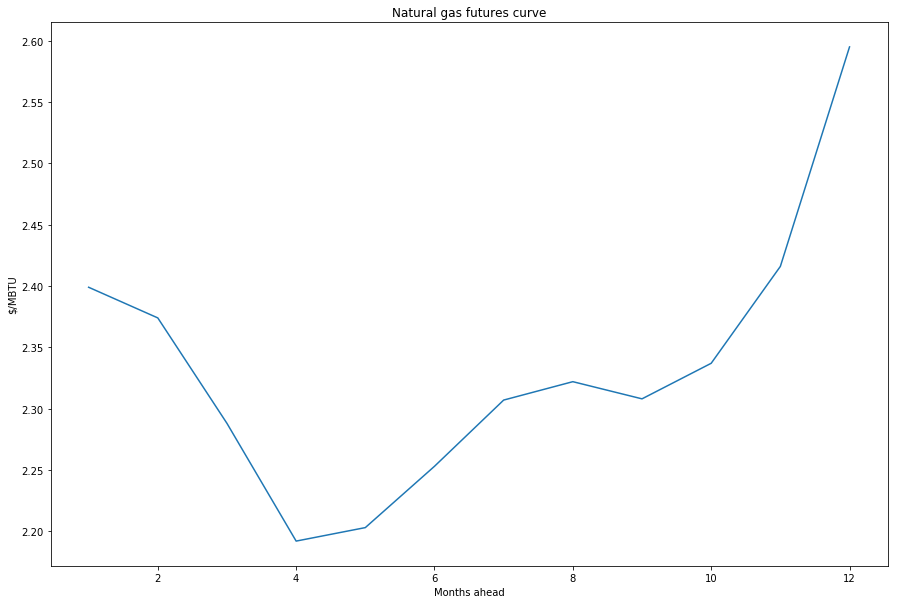

In [4]:
tickers = ['NG' + str(i) + ' Comdty' for i in range(1,13)]

bbg_data = bbg.fetch_series(securities=tickers,
                               fields='PX_LAST',
                               startdate=ref_date,
                               enddate=ref_date)
bbg_data.columns = [int(x.replace('NG','').replace(' Comdty','')) for x in bbg_data.columns]
bbg_data.sort_index(axis=1)
plt.figure(figsize=(15,10))
bbg_data.iloc[-1].sort_index().plot(title='Natural gas futures curve')
plt.ylabel('$/MBTU')
plt.xlabel('Months ahead')
plt.show()

In order to avoid the definition of carry moving up and down seasonally, carry strategies in commodities often look at $T$ and $T_{0}$ exactly one year apart. However, this not always true. Some people may argue that you want carry to move up and down seasonally because the underlying spot markets do so.

### Carry in rates

#### Carry in zero coupon bonds

When we have data on a zero-coupon rates curve, we can also apply the same carry definition as in FX forward contracts or commodity futures. Let's suppose we want to calculate carry on zero coupon bon with maturity $\tau$ years ahead. Since we have a zero-coupon rates curve, we know the yield of this zero coupon bond, $y_{t}^{\tau}$, on date $t$. Asuming without loss of generality that the bond pays 1 as principal, the spot price of this bond is then given by $P_{t}^{\tau} = (1+y_{t}^{\tau})^{-\tau}$.

So, what is the expected return of this bond over a time period $h$ if there is no change in underlying prices, i.e., the zero-coupon rates curve remains the same? Well, after $h$ time periods have passed, this bond will now have maturity equal to $\tau-h$ years and therefore, if the zero-coupon rates curve remains the same, it will have price: $P_{t+h}^{\tau-h} = P_{t}^{\tau-h} = (1+y_{t}^{\tau-h})^{-\tau+h}$. Hence, the annualized total return of buying a zero coupon bond of maturity $\tau$ years and holding it for $h$ years is:

$$
\Big(\frac{P_{t+h}^{\tau-h}}{P_{t}^{\tau}}\Big)^{1/h}-1= \frac{(1+y_{t}^{\tau})^{\tau/h}}{(1+y_{t}^{\tau-h})^{(\tau-h)/h}}-1.
$$

The chapter *A Framework for Analyzing Yield-curve trades* in [Fabozzi's book](https://www.amazon.com/Handbook-Fixed-Income-Securities-Eighth/dp/0071768467) will show that the expression on the right hand side of the equation above is in fact the $h$ years rate $\tau-h$ years forward, i.e., the so-called $\tau-h:h$ years forward rate, denoted here by $f_{t}^{\tau-h:h}$. The  $\tau-h:h$ years forward rate is the non-arbitrage $h$ years rate implied by the current zero-coupon curve that is suppose to prevalent during the time period in between $\tau-h$ and $\tau$. Hence, the annualized total return of buying a zero coupon bond of maturity $\tau$ years and holding it for $h$ years is $f_{t}^{\tau-h:h}$.

However, note that buying a zero coupon bond requires some actual cash. This cash which is required duing $h$ years needs to be remunerated at the $y_{t}^{h}$ rate. So, the actual carry of a zero-coupon bond, or any no-coupon paying derivative, with maturity $\tau$ is:

$$
Carry_{\tau}^{h} = \frac{1+f_{t}^{\tau-h:h}}{1+y_{t}^{h}}-1.
$$

#### Carry in coupon paying bonds

When we do not have data on a zero-coupon rates curve, calculating carry is a bit different. We still know the bond, $y_{t}^{\tau}$, on date $t$ and its price $P_{t}^{\tau}$. After $h$ time periods have passed, this bond will now have maturity equal to $\tau-h$ years and therefore, if the yield curve remains the same, it will have price: $P_{t+h}^{\tau-h} = P_{t}^{\tau-h}$ and yield equal to $y_{t}^{\tau-h}$.

Using the arguemnts in the chapter *A Framework for Analyzing Yield-curve trades* in [Fabozzi's book](https://www.amazon.com/Handbook-Fixed-Income-Securities-Eighth/dp/0071768467) one can show that the annualized total return of buying a bond of maturity $\tau$ years and holding it for $h$ years can be approximated by:

$$
\Big(\frac{P_{t+h}^{\tau-h}}{P_{t}^{\tau}}\Big)^{1/h}-1 \approx y_{t}^{\tau} - \frac{D_{t}^{\tau-h}}{h} \times (y_{t}^{\tau-h}-y_{t}^{\tau})
$$

where $D_{t}^{\tau-h}$ is the modified duration of a bond with maturity $\tau-h$.

Again, buying a bond requires some actual cash which needs to be remunerated at the $y_{t}^{h}$ rate. So, the actual carry of a a bond, or any similar derivative, with maturity $\tau$ can be approximated by:

$$
Carry_{\tau}^{h} \approx \underbrace{(y_{t}^{\tau}  - y_{t}^{h})}_\text{slope}   - \underbrace{\frac{D_{t}^{\tau-h}}{h} \times (y_{t}^{\tau-h}-y_{t}^{\tau})}_\text{roll down}
$$

As dicussed in [Koijen, Moskowitz, Pedersen, and Vrugt (2016)](https://ssrn.com/abstract=2298565) the equation above shows that the bond carry consists of two effects: (i) the bond’s yield spread to the risk-free rate, which is also called the **slope** of the term structure; plus (ii) the **roll down** which captures the price increase due to the fact that the bond rolls down the yield curve. The idea of the second component is that if the entire yield curve stays constanto, the bond "rolls down" the
yield curve and it will now have yield $y_{t}^{\tau-h}$, resulting in a price appreciation that can be measured by the change in yields times the modified duration.

In many case, the magnitude of the roll down component is small relative to the slope component. So, from time to time you will see carry strategies in rates defining carry simply as the slope component, i.e., $Carry_{\tau}^{h} \approx y_{t}^{\tau}  - y_{t}^{h}$. This approximation is sometimes called **cash carry** while the previous one is sometimes called **total carry**.


#### Carry in interest rate swaps

We want to calculate the carry of holding a vanilla (fixed vs floating) interest rate swap in a particular currency. Here, we can actually use the same logic we used when calculating carry in FX using forward contracts. Let's denote the spot swap rate by $y^{\tau}$. If there are $h:\tau+h$ forward starting swaps available, they will trade at rate $y^{h:\tau+h}$. The carry for holding the $\tau$ years swap over $h$ periods should be equal to the expected return from holding a $h:\tau+h$ forward starting swaps to its maturity at time ${\tau}$.

Again using the arguements from the chapter *A Framework for Analyzing Yield-curve trades* in [Fabozzi's book](https://www.amazon.com/Handbook-Fixed-Income-Securities-Eighth/dp/0071768467) one can approximate the return of a  $h:\tau+h$ forward starting swaps by:

$$
Carry_{\tau}^{h} \approx D_{\tau} \times \Delta y \approx \frac{D_{\tau}}{h} \times (y^{h:\tau+h}-y_{t}^{\tau})
$$

#### Carry across G10 IRS

Let's see how all this looks in practice. Let's calcualte the 6M carry in 10Y rates across G10:

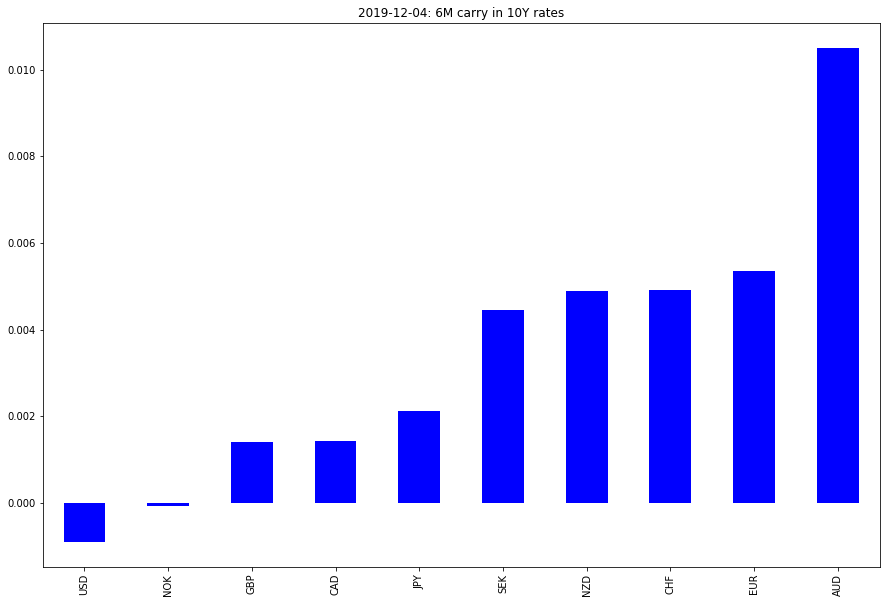

In [5]:
# get spot 10Y rates tickers
spot_IRS = pd.Series({
    'USD':'USSW10 Curncy',
    'EUR':'EUSA10 Curncy',
    'JPY':'JYSW10 Curncy',
    'GBP':'BPSW10 Curncy',
    'AUD':'ADSW10Q Curncy',
    'CAD':'CDSW10 Curncy',
    'SEK':'SKSW10 Curncy',
    'CHF':'SFSW10  Curncy',
    'NOK':'NKSW10 Curncy',
    'NZD':'NDSWAP10 Curncy',
})


swap_rates = bbg.fetch_series(securities=list(spot_IRS.values),
                                       fields='PX_LAST',
                                       startdate=ref_date,
                                       enddate=ref_date)
swap_rates.columns = [spot_IRS.index[list(spot_IRS.values).index(x)] for x in list(swap_rates.columns)]


# 6M forward 10Y rates tickers
fwd_6M_IRS = pd.Series({
    'USD':'USFS0F10 Curncy',
    'EUR':'EUSAF10 Curncy',
    'JPY':'JYFS0F10 Curncy',
    'GBP':'BPSW0F10 Curncy',
    'AUD':'S0302FS 6M10Y BLC Curncy',
    'CAD':'CDFS0F10 Curncy',
    'SEK':'SKFS0F10 Curncy',
    'CHF':'SFFS0F10 Curncy',
    'NOK':'S0313FS 6M10Y BLC Curncy',
    'NZD':'NDFS0F10 Curncy',
})

swap_6M_fwd_rates = bbg.fetch_series(securities=list(fwd_6M_IRS.values),
                                       fields='PX_LAST',
                                       startdate=ref_date,
                                       enddate=ref_date)
swap_6M_fwd_rates.columns = [fwd_6M_IRS.index[list(fwd_6M_IRS.values).index(x)] for x in list(swap_6M_fwd_rates.columns)]


durations = bbg.fetch_contract_parameter(securities=list(spot_IRS.values), field='DUR_ADJ_BID')
durations.index = [spot_IRS.index[list(spot_IRS.values).index(x)] for x in list(durations.index)]
durations = durations.iloc[:,0]

# calculate  carry
carry = durations*(swap_6M_fwd_rates - swap_rates).iloc[0]/100
plt.figure(figsize=(15,10))
carry.sort_values().plot(kind='bar', color='b',
                        title='%s: 6M carry in 10Y rates' % ref_date)
plt.show()

### Carry in equity indices

For equities, we can also use the same arguemnt we used for FX forward contracts. The no-arbitrage price of a futures contract, $F_{t}$ depends on the current equity value $S_{t}$, the expected future dividend payment $D_{t+1}$ computed under the risk-neutral measure and the risk-free interest rate in the country of the equity index. So, $F_{t}=S_{t}(1+r_{f})-E^{Q}[D_{t+1}]$ and therefore:

$$
Carry_{eq} = \frac{S_{t}}{F_{t}} -1 = \Big(\underbrace{ \frac{E^{Q}[D_{t+1}]}{S_{t}}}_\text{div yield}-r_{f}\Big) \frac{S_{t}}{F_{t}}
$$

In practice, historical dividend yields can be quite different from $E^{Q}[D_{t+1}]/S_{t}$ so, calculating carry over $h$ periods in equity indices is simply:

$$
Carry_{eq}^{h} = \Big(\frac{S_{t}}{F_{t}}\Big)^{1/h} -1
$$

Let's use S&P futures to illustrate:

In [6]:
front_month = bbg.fetch_contract_parameter(securities='SP1 Comdty', field='FUT_CUR_GEN_TICKER')
expiry = bbg.fetch_contract_parameter(securities=front_month.iloc[0,0] + ' Index', field='FUT_NOTICE_FIRST')
h = (pd.to_datetime(expiry.iloc[0,0]) - pd.to_datetime('today')).days/365.25

bbg_data = bbg.fetch_series(securities=['SP1 Comdty'] + ['SPX Index'],
                               fields='PX_LAST',
                               startdate=pd.to_datetime('today'),
                               enddate=pd.to_datetime('today'))
carry = (bbg_data['SPX Index']/bbg_data['SP1 Comdty'])**(1/h)-1
print('On %s, the carry on the front month S&P future is: %s' % (carry.index[0].strftime('%d-%b-%y'),carry.iloc[0]))

On 28-Jan-20, the carry on the front month S&P future is: 0.0007568960130031055


### Carry in bond futures

Calculating carry for bond futures is similar to calculating carry for any futures contract and it follows pretty much the same lines as calculating carry for forward FX contract. The tricky part about bond futures is that the underlying $i$ keeps changing. At any one point in time, the bond underlying a bond futures is called the *cheapest-to-deliver* (CTD) because it is the cheapest bond meeting the futures contract criteria that can be physically delivered to settle a futures contract at maturity. Associated to the CTD bond there is a conversion factor $k$ that makes the price of the bond (quoted in relation to 100 par bond) comparable with the bond futures price quoted on the screen. So, if you buy a bond via a bond future at price $F_{i}^{T}$ and the CTD bond has price $P_{i}$ at $T$, then you will profit: $F_{i}^{T} \times k - P_{i}$. Hence, for 100 par bond, the annualized total returns on this strategy is given by:

$$
Carry_{i}^{T} = \Big(1+\frac{F_{i}^{T} \times k - P_{i}}{100}\Big)^{1/T}-1
$$

In [7]:
front_month_ticker = bbg.fetch_contract_parameter(securities='TY1 Comdty', field='FUT_CUR_GEN_TICKER')
front_month_ticker = front_month_ticker.iloc[0,0] + ' Comdty'
expiry = bbg.fetch_contract_parameter(securities=front_month_ticker, field='LAST_TRADEABLE_DT')
h = (pd.to_datetime(expiry.iloc[0,0])-pd.to_datetime('today')).days/365.25
ctd_cusip = bbg.fetch_contract_parameter(securities=front_month_ticker, field='FUT_CTD_CUSIP')
ctd_cusip = ctd_cusip.iloc[0,0] + ' Govt'
conv_factor = bbg.fetch_contract_parameter(securities=front_month_ticker, field='FUT_CNVS_FACTOR')
conv_factor = conv_factor.iloc[0,0]

bbg_data = bbg.fetch_series(securities=[front_month_ticker,ctd_cusip],
                               fields='PX_LAST',
                               startdate=pd.to_datetime('today'),
                               enddate=pd.to_datetime('today'))

fut_price = bbg_data.iloc[0,0]*conv_factor
bond_price = bbg_data.iloc[0,1]
carry = (1+(fut_price-bond_price)/100)**(1/h)-1
print('On %s, the carry on the front month 10Y UST future is: %s' % (pd.to_datetime('today').strftime('%d-%b-%y'),carry))

On 28-Jan-20, the carry on the front month 10Y UST future is: -0.001715206652355361


## Exercises

#### Beginners

Try to calculate carry for a few assets and create some code to run some regressions like on future returns on the carry metric or the chance in carry signal. Also, think about the case where the carry signal (or the chance in carry signal) is supposed to predict direction (so if the underlying is going up or down) and not predict the actual realized future returns.

#### Intermediate

Calculate a time series carry strategies as in  [Baz, Granger, Harvey, Le Roux, and Rattray (2015)](https://www.cmegroup.com/education/files/dissecting-investment-strategies-in-the-cross-section-and-time-series.pdf) or in [Baltas (2017)](https://doi.org/10.1016/B978-1-78548-201-4.50013-1)


#### Intermediate

Create a class to calculate carry for one asset class.

#### Advanced

Create a class to calculate carry for all asset classes covered here in this notebook.

#### Jedi Master

Carry out the Advanced task above and make a contribution to [FinanceHub's signals class](https://github.com/Finance-Hub/FinanceHub/tree/master/signals).